<a href="https://colab.research.google.com/github/liuchenbaidu/colab_code/blob/main/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [18]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [1]:
!nvidia-smi

Thu Dec  1 10:01:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip install tensorflow==1.15

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [12]:
batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]

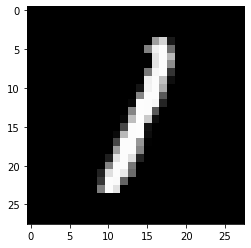

In [11]:
plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
plt.show()

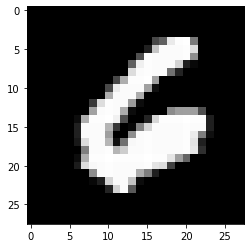

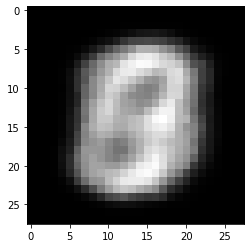

In [13]:
plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
plt.show()
plt.imshow(d[0], cmap='gray')
plt.show()

In [8]:
# batch[0]

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


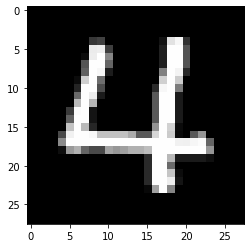

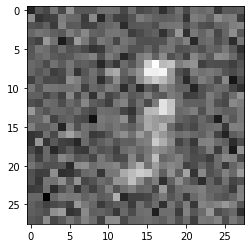

0 176.983 176.97772 0.0052747466


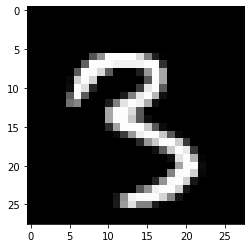

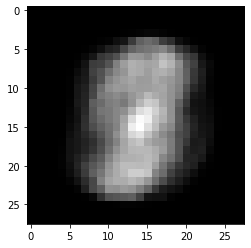

200 46.353333 44.449013 1.9043181


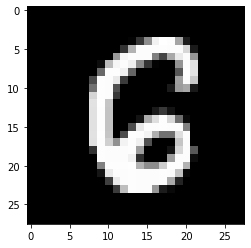

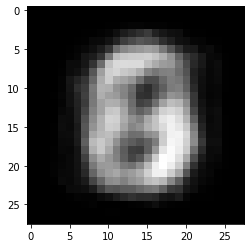

400 41.400803 35.761276 5.639527


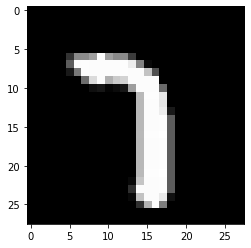

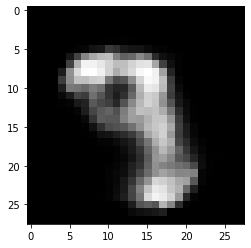

600 37.41658 30.234192 7.1823864


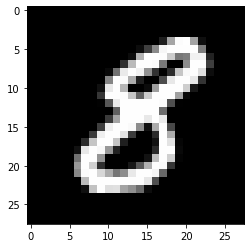

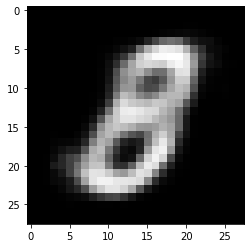

800 32.473892 24.79614 7.6777525


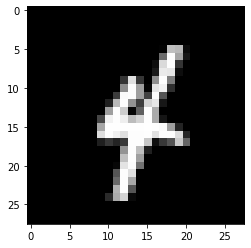

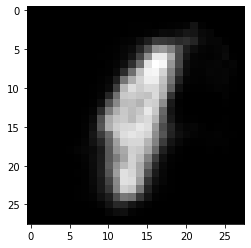

1000 34.605774 26.813028 7.792744


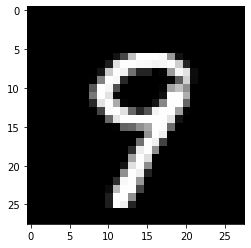

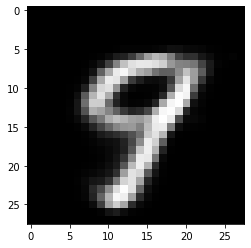

1200 32.341187 24.551128 7.790056


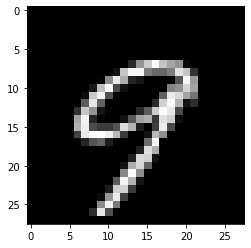

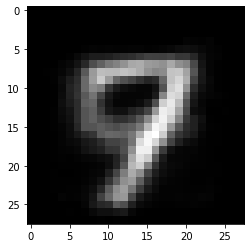

1400 33.217224 24.776482 8.440746


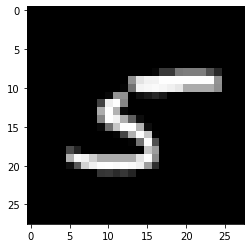

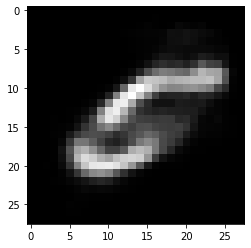

1600 33.522934 24.623243 8.899691


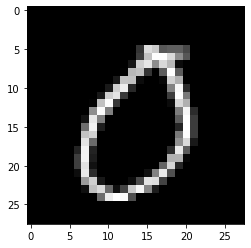

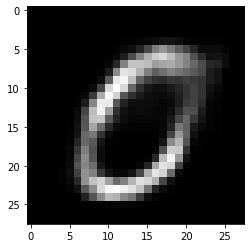

1800 32.773342 23.699001 9.074339


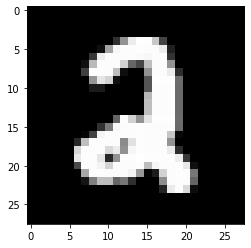

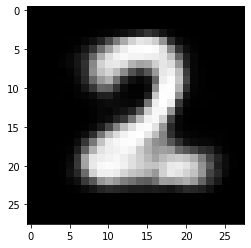

2000 32.49248 23.164396 9.328083


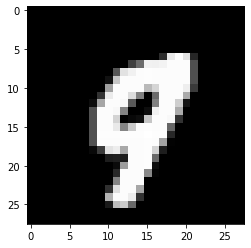

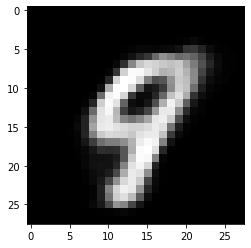

2200 30.71838 21.238438 9.479942


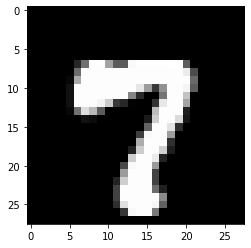

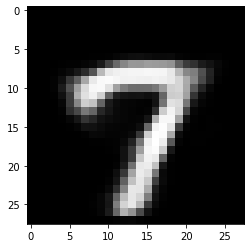

2400 30.969545 21.608234 9.361311


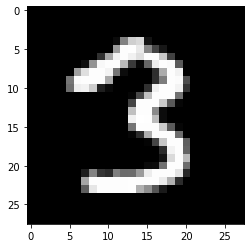

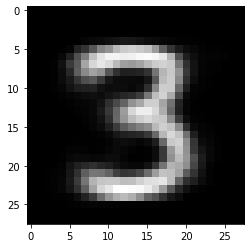

2600 30.01202 20.807787 9.204231


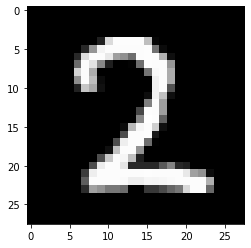

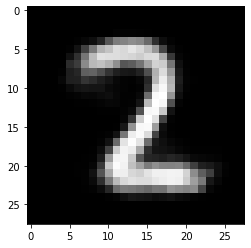

2800 30.868443 21.056452 9.811991


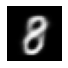

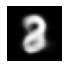

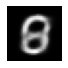

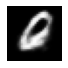

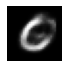

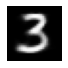

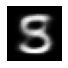

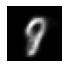

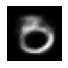

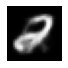

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data')#28*28的单色道图像数据

tf.reset_default_graph()

batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])#用于计算损失函数
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')#dropout比率

dec_in_channels = 1
n_latent = 8 #隐变量的维度设置

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels // 2


def lrelu(x, alpha=0.3):#自定义Leaky ReLU函数使效果更好
    return tf.maximum(x, tf.multiply(x, alpha))

#编码
def encoder(X_in, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        
        #q(z|X)，需要通过一批次的X来随机的生成z（z的条件分布也需要不断学习）
        mn = tf.layers.dense(x, units=n_latent) #利用计算means
        sd       = 0.5 * tf.layers.dense(x, units=n_latent) #利用计算standard         
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) #从正态分布中采样
        z  = mn + tf.multiply(epsilon, tf.exp(sd)) 
        return z, mn, sd

#解码
def decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        x = tf.layers.dense(x, units=inputs_decoder * 2 + 1, activation=lrelu)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        
        #还原成28x28
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28])
        return img

#结合
sampled, mn, sd = encoder(X_in, keep_prob)
dec = decoder(sampled, keep_prob)

#损失函数的计算由两部分组成
unreshaped = tf.reshape(dec, [-1, 28*28])
#最大似然
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
#KL散度
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# for i in range(30000):#开始训练
for i in range(3000):#开始训练
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    sess.run(optimizer, feed_dict = {X_in: batch, Y: batch, keep_prob: 0.8})
        
    if not i % 200:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        plt.show()
        plt.imshow(d[0], cmap='gray')# 打印解码器生成的图片
        plt.show()
        print(i, ls, np.mean(i_ls), np.mean(d_ls))# 打印损失和方差

#单独拿出来可以用于生成新的字符 生成10张图片
randoms = [np.random.normal(0, 1, n_latent) for _ in range(10)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')

